# Prepare the document store

In [1]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
from datasets import load_dataset
from haystack import Document
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.document_stores.types import DuplicatePolicy

# Initialize the document store
document_store = InMemoryDocumentStore()

# Fetch the data and convert it into Haystack Documents
dataset = load_dataset("covid_qa_deepset", split="train")
unique_text = list(set(dataset["context"]))
chunk_size = 500
text_chunks = []
for text in unique_text:
    text_chunks = text_chunks + [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
docs = [Document(content=doc) for doc in text_chunks]

# Initalize a Document Embedder
doc_embedder = SentenceTransformersDocumentEmbedder(model="paraphrase-MiniLM-L3-v2")
doc_embedder.warm_up()

# Write Documents to the DocumentStore
docs_with_embeddings = doc_embedder.run(docs)
document_store.write_documents(docs_with_embeddings["documents"], policy=DuplicatePolicy.SKIP)


c:\Users\thelo\Medical-QA-LLM\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\thelo\Medical-QA-LLM\venv\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\thelo\.cache\huggingface\hub\models--sentence-transformers--paraphrase-MiniLM-L3-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In 

7804

# Build RAG pipeline

## Set up pipeline components

In [2]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
import os
from getpass import getpass
from haystack.components.generators import HuggingFaceLocalGenerator
import torch

# Initialize a Text Embedder
text_embedder = SentenceTransformersTextEmbedder(model="paraphrase-MiniLM-L3-v2")

# Initialize the Retriever
retriever = InMemoryEmbeddingRetriever(document_store)

# Define a Template Prompt
template = """
Given the following information, answer the question.

Context: 
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{ question }}?
"""

prompt_builder = PromptBuilder(template=template)

# Check GPU
if torch.cuda.is_available():
    print("GPU used:", torch.cuda.get_device_name(0))
    
# Initialize a Generator
generator = HuggingFaceLocalGenerator(model="google/flan-t5-large",
                                      task="text2text-generation",
                                      generation_kwargs={
                                        "max_new_tokens": 200,
                                        "do_sample": False,
                                        "num_beams": 1
                                        })

generator.warm_up()

GPU used: NVIDIA GeForce RTX 3080


c:\Users\thelo\Medical-QA-LLM\venv\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Build the pipeline

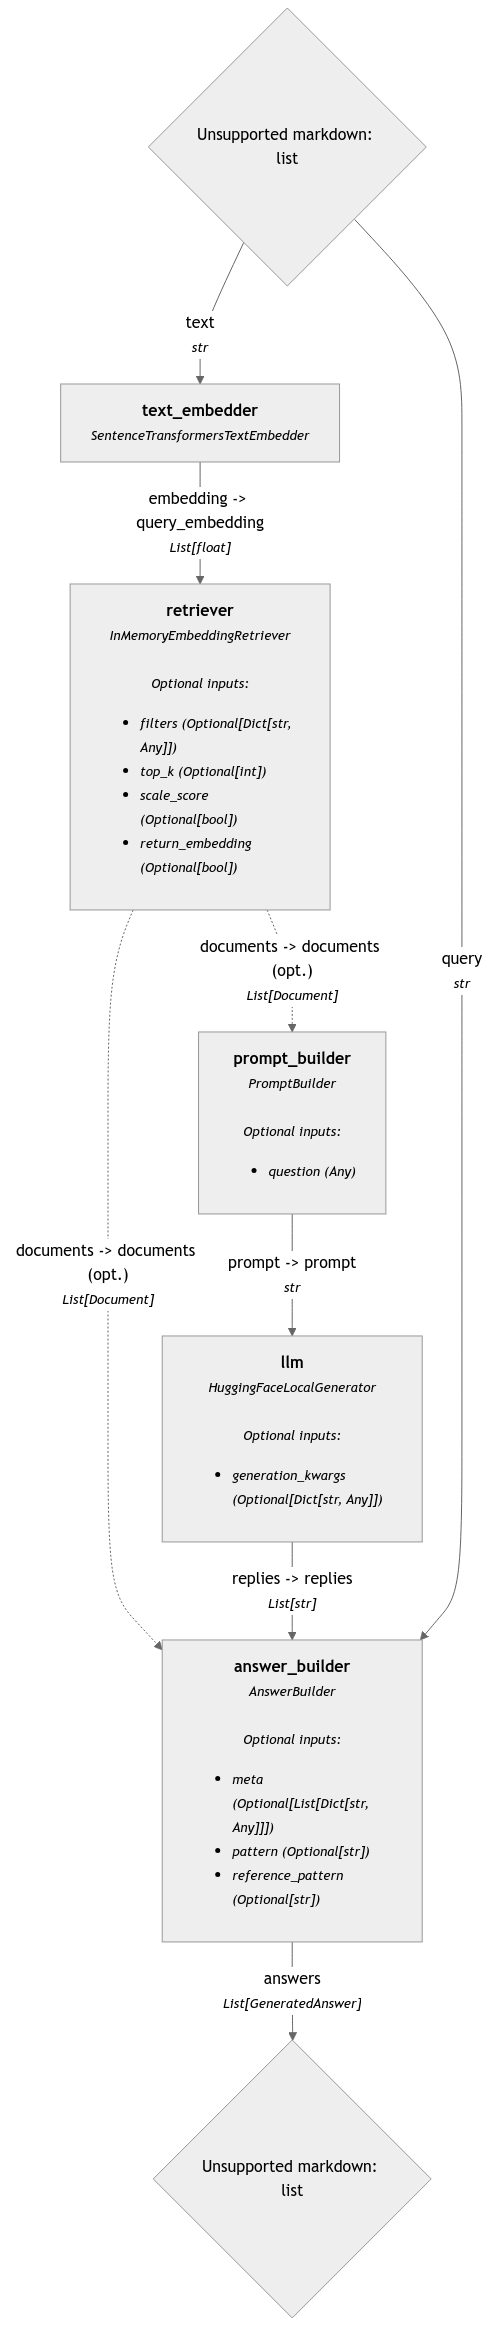

In [3]:
from haystack import Pipeline
from haystack.components.builders.answer_builder import AnswerBuilder

rag_pipeline = Pipeline()
# Add components to your pipeline
rag_pipeline.add_component("text_embedder", text_embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)
rag_pipeline.add_component(instance=AnswerBuilder(), name="answer_builder")

# Now, connect the components to each other
rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")
rag_pipeline.connect("llm.replies", "answer_builder.replies")
rag_pipeline.connect("retriever", "answer_builder.documents")

## Ask questions

In [4]:
# Function to get both response and retrieved context
def get_contexts_and_responses(questions, pipeline):
    contexts = []
    responses = []
    for question in questions:
        response = pipeline.run(
            {
                "text_embedder": {"text": question},
                "prompt_builder": {"question": question},
                "answer_builder": {"query": question},
            }
        )

        contexts.append([d.content for d in response["answer_builder"]["answers"][0].documents])
        responses.append(response["answer_builder"]["answers"][0].data)
    return contexts, responses

In [5]:
questions = ["How many children were infected by HIV-1 in 2008-2009, worldwide?"]#more than 400,000 children were infected worldwide, mostly through MTCT and 90% of them lived in sub-Saharan Africa.
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches: 100%|██████████| 1/1 [00:00<00:00, 197.82it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (1269 > 512). Running this sequence through the model will result in indexing errors


['around']

In [6]:
questions = ["What is the main cause of HIV-1 infection in children?"]#Mother-to-child transmission (MTCT) is the main cause of HIV-1 infection in children worldwide.
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches: 100%|██████████| 1/1 [00:00<00:00, 197.59it/s]


['mother-to-child transmission']

In [7]:
questions = ["What could trigger acute necrotizing encephalopathy?"]#viral infection in previously healthy children
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches: 100%|██████████| 1/1 [00:00<00:00, 200.54it/s]


['viral infection']

In [8]:
questions = ["How many open reading frames are in the HMPV genome?"] #eight
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches: 100%|██████████| 1/1 [00:00<00:00, 246.06it/s]


['143']

In [9]:
questions = ["Who accounted for 44% of HMPV positive cases in Kenya between 2007 and 2011?"]# "children under 6 months of age"
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches: 100%|██████████| 1/1 [00:00<00:00, 197.94it/s]


['children under 6 months of age']

In [10]:
questions = ["What is the primary reservoir for Coxiella burnetii?"] # sheep, goat and cattle
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches: 100%|██████████| 1/1 [00:00<00:00, 200.54it/s]


['rodent']

In [11]:
questions = ["What was the clinical attack rate in the 2009 H1N1 pandemic?"] # 20%"
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches: 100%|██████████| 1/1 [00:00<00:00, 165.66it/s]


['183%']

In [12]:
questions = ["Approximately how many people died during the 1918-1919 influenza pandemic?"] # During the 1918-1919 influenza pandemic, between 21 and 25 million people died of influenza worldwide.
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches: 100%|██████████| 1/1 [00:00<00:00, 186.17it/s]


['between 21 and 25 million']

In [13]:
questions = ["What is the structure of the Ebolavirus?"] # single-strand RNA filoviruses
contexts, responses = get_contexts_and_responses(questions, rag_pipeline)
responses

Batches: 100%|██████████| 1/1 [00:00<00:00, 200.58it/s]


['single-strand RNA filoviruses']